<a href="https://colab.research.google.com/github/moreharsh/Video-Summary-Generation/blob/main/Video_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshmo","key":"79be08a668418687406df4aaed011e97"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:31<00:00, 25.6MB/s]
100% 1.04G/1.04G [00:31<00:00, 35.1MB/s]


In [ ]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# KeyFrame Extraction

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs

def getKeyframes(path):
  # Cell 1

  cap = cv2.VideoCapture(path) 
  arr = np.empty((0, 1944), int)
  D = dict()
  count = 0
  start_time = time.time()
  while cap.isOpened():
      ret, frame = cap.read()
      if ret == True:
          frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          D[count] = frame_rgb   
          height, width, channels = frame_rgb.shape

          if height % 3 == 0:
              h_chunk = int(height/3)
          else:
              h_chunk = int(height/3) + 1

          if width % 3 == 0:
              w_chunk = int(width/3)
          else:
              w_chunk = int(width/3) + 1

          h = 0
          w = 0 
          feature_vector = []
          for a in range(1,4):
              h_window = h_chunk*a
              for b in range(1,4):
                  frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                  hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])#finding histograms for each block  
                  hist1= hist.flatten()  #flatten the hist to one-dimensinal vector 
                  feature_vector += list(hist1)
                  w = w_chunk*b
                  
              h = h_chunk*a
              w = 0
          arr = np.vstack((arr, feature_vector ))
          count+=1
      else:
          break
  final_arr = arr.transpose()

  # Cell 2
  A = csc_matrix(final_arr, dtype=float)
  u, s, vt = svds(A, k = 63)

  # Cell 3
  v1_t = vt.transpose()
  projections = v1_t @ np.diag(s)

  # Cell 4
  f=projections
  C = dict()
  for i in range(f.shape[0]):
      C[i] = np.empty((0,63), int)
  C[0] = np.vstack((C[0], f[0]))   
  C[0] = np.vstack((C[0], f[1]))

  E = dict()
  for i in range(projections.shape[0]):
      E[i] = np.empty((0,63), int)
      
  E[0] = np.mean(C[0], axis=0)

  count = 0
  for i in range(2,f.shape[0]):
      similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) 
      if similarity < 0.9:
          count+=1         
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)   
      else:
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)

  # Cell 5
  b = []
  for i in range(f.shape[0]):
      b.append(C[i].shape[0])
  last = b.index(0) 
  b1=b[:last]

  # Cell 6
  res = [idx for idx, val in enumerate(b1) if val >= 25]

  # Cell 7
  GG = C
  for i in range(last):
      p1= np.repeat(i, b1[i]).reshape(b1[i],1)
      GG[i] = np.hstack((GG[i],p1))

  # Cell 8
  F =  np.empty((0,64), int) 
  for i in range(last):
      F = np.vstack((F,GG[i]))
    
  # Cell 9
  colnames = []
  for i in range(1, 65):
      col_name = "v" + str(i)
      colnames+= [col_name]
  df = pd.DataFrame(F, columns= colnames)

  # Cell 10
  df['v64']= df['v64'].astype(int)

  # Cell 11
  df1 =  df[df.v64.isin(res)]

  # Cell 12
  new = df1.groupby('v64').tail(1)['v64']

  # Cell 13
  new1 = new.index

  # Cell 14
  i = 0
  for c in new1:
    frame_rgb1 = cv2.cvtColor(D[c], cv2.COLOR_RGB2BGR) #since cv consider image in BGR order
    frame_num_chr = str(c)
    file_name = 'frame'+ str(i) +'.png'
    cv2.imwrite(file_name, frame_rgb1)
    i += 1
  return i

# Import Libraries

In [ ]:
import tensorflow as tf

In [ ]:
import string
import os.path
from os import path
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
print("Num of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num of GPUs:  1


In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
print(tf.version.VERSION)

2.7.0


# Load Dataset & Preprocessing

In [ ]:
image_path = "./Images"
dir_Flickr_text = "./captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [ ]:
import os.path
from os import path

In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split(',')
   if len(col) == 1:
       continue
   w = col[0]
   if(path.isfile(image_path+"/"+w)):
     datatxt.append([w] + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
data = data.reindex(columns =['filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,filename,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [ ]:
from keras.preprocessing.image import load_img, img_to_array

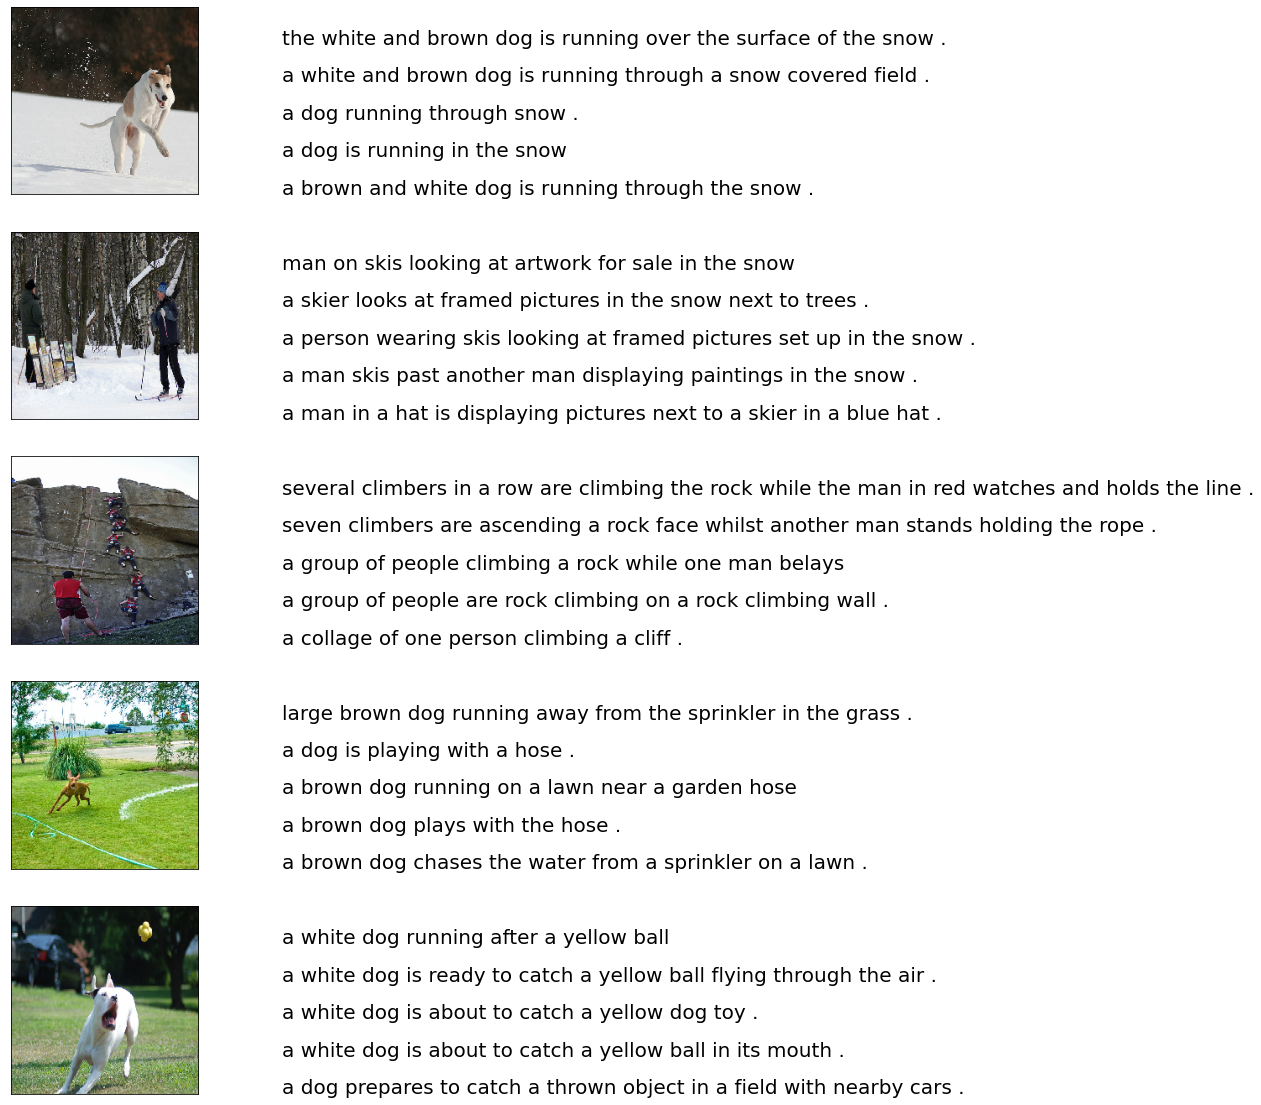

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8871


In [ ]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)


In [ ]:
def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

In [ ]:
for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8182


# InceptionV3 Model

In [ ]:
PATH = "./Images/"
all_captions = []
for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   if(path.isfile(full_image_path)):
     all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['./Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1000268201_693b08cb0e.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg',
 './Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Get unique images

encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [01:57<00:00,  4.30it/s]


# Tokenizer

In [ ]:
top_k = 5000

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(40000, 31)

# Split the data into training and testing

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Positional Encoding 

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# MultiHead Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder & Decoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar , training, look_ahead_mask, dec_padding_mask=None, enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

# Model Hyperparameters

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

# Learning rate, Optimizer, loss function

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

# Training Starts

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp,
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(5):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5515 Accuracy 0.0005
Epoch 1 Batch 50 Loss 8.0951 Accuracy 0.0222
Epoch 1 Batch 100 Loss 7.6905 Accuracy 0.0277
Epoch 1 Batch 150 Loss 7.3921 Accuracy 0.0301
Epoch 1 Batch 200 Loss 7.1014 Accuracy 0.0328
Epoch 1 Batch 250 Loss 6.8328 Accuracy 0.0361
Epoch 1 Batch 300 Loss 6.5903 Accuracy 0.0397
Epoch 1 Batch 350 Loss 6.3747 Accuracy 0.0434
Epoch 1 Batch 400 Loss 6.1852 Accuracy 0.0469
Epoch 1 Batch 450 Loss 6.0161 Accuracy 0.0502
Epoch 1 Loss 5.8681 Accuracy 0.0531
Time taken for 1 epoch: 246.17042779922485 secs

Epoch 2 Batch 0 Loss 4.4857 Accuracy 0.0932
Epoch 2 Batch 50 Loss 4.3968 Accuracy 0.0830
Epoch 2 Batch 100 Loss 4.3357 Accuracy 0.0844
Epoch 2 Batch 150 Loss 4.2936 Accuracy 0.0849
Epoch 2 Batch 200 Loss 4.2383 Accuracy 0.0862
Epoch 2 Batch 250 Loss 4.1946 Accuracy 0.0874
Epoch 2 Batch 300 Loss 4.1502 Accuracy 0.0884
Epoch 2 Batch 350 Loss 4.1151 Accuracy 0.0891
Epoch 2 Batch 400 Loss 4.0718 Accuracy 0.0901
Epoch 2 Batch 450 Loss 4.0357 Accuracy 0.0910
E

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# !mkdir -p saved_model
# transformer.save('saved_model/my_model')

In [ ]:
# new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
transformer.save_weights('./gdrive/MyDrive/Colab Notebooks/my_transformer/', save_format='tf')

Training Ends

# Load Model and Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transformer34 = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
transformer34.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9))

In [ ]:
@tf.function
def train_step34(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer34(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer34.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer34.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
start = time.time()

train_loss.reset_states()
train_accuracy.reset_states()

for (batch, (img_tensor, tar)) in enumerate(dataset):
  train_step34(img_tensor, tar)
  
  print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
        1, batch, train_loss.result(), train_accuracy.result()))
  if batch % 100 == 0:
    break
  
print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(1, 
                                              train_loss.result(), 
                                              train_accuracy.result()))

print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.6091 Accuracy 0.0000
Epoch 1 Loss 8.6091 Accuracy 0.0000
Time taken for 1 epoch: 12.345640182495117 secs



In [ ]:
transformer34.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transformer34.load_weights('./drive/MyDrive/Colab Notebooks/my_transformer/')

In [ ]:
transformer34.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  13658624  
                                                                 
 decoder (Decoder)           multiple                  19376640  
                                                                 
 dense_65 (Dense)            multiple                  2565513   
                                                                 
Total params: 35,600,777
Trainable params: 35,600,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# transformer.summary()

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer34(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 25.773347954661457
BLEU-2 score: 42.08770096808337
BLEU-3 score: 51.20931300249215
BLEU-4 score: 53.78329261427206
Real Caption: little boy is going down blue and red slip and slide
Predicted Caption: boy in blue shorts is jumping into pool


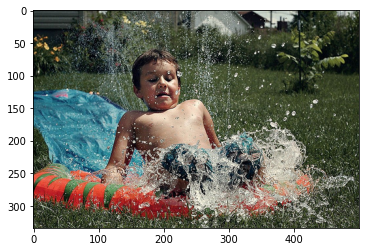

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

# Test Starts

In [ ]:
Summary_Table = pd.DataFrame(columns=["Input_Video","Manual_Summary","HuggingFace_Summarizer"])

In [ ]:
Evaluation_Table_Bleu = pd.DataFrame(columns=["Input_Video","Summarizer","BLEU-1","BLEU-2","BLEU-3","BLEU-4"])

In [ ]:
Evaluation_Table_Rouge = pd.DataFrame(columns=["Input_Video","Summarizer","Rouge1-precision","Rouge1-recall","Rouge1-fmeasure","RougeL-precision","RougeL-recall","RougeL-fmeasure"])

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 3.3 MB 30.2 MB/s 
     |████████████████████████████████| 61 kB 527 kB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install rouge/requirements.txt
!pip install rouge-score

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


## For Input 1: (Olympics)

In [ ]:
keyframes = getKeyframes('./drive/MyDrive/Colab Notebooks/input1.mp4')

In [ ]:
keyframes

75

In [ ]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  print (' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "

the large white dog is driving the green toy
little girl in pink shirt is jumping in the air
the boy is wearing blue shirt and white shirt
the little girl is jumping over the hurdle
the girl is jumping in the air
the man is performing trick on the green horse
the baseball player is jumping over the hurdle
the baseball player is jumping up
man does trick on skateboard
two men are running around in race
the snowboarder is jumping over the water
two people are in the air
girl in pink dress and blue dress is wearing pink swimsuit
girl in pink shirt plays with guitar
girl in pink dress and pink dress is jumping in the air
the little girl is wearing red shirt and blue shirt and blue shirt
the little girl is jumping up in the air
the little girl is jumping on the swing
basketball player in white jersey is jumping up up up the ball
basketball player in white shirt is jumping up up up the ball
basketball player in white jersey is trying to get the ball
the skateboarder is jumping over the hurdl

In [ ]:
big_caption

'the large white dog is driving the green toy. little girl in pink shirt is jumping in the air. the boy is wearing blue shirt and white shirt. the little girl is jumping over the hurdle. the girl is jumping in the air. the man is performing trick on the green horse. the baseball player is jumping over the hurdle. the baseball player is jumping up. man does trick on skateboard. two men are running around in race. the snowboarder is jumping over the water. two people are in the air. girl in pink dress and blue dress is wearing pink swimsuit. girl in pink shirt plays with guitar. girl in pink dress and pink dress is jumping in the air. the little girl is wearing red shirt and blue shirt and blue shirt. the little girl is jumping up in the air. the little girl is jumping on the swing. basketball player in white jersey is jumping up up up the ball. basketball player in white shirt is jumping up up up the ball. basketball player in white jersey is trying to get the ball. the skateboarder is 

# Score Evaluation

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
generated_caption = big_caption

In [ ]:
generated_caption

'the large white dog is driving the green toy. little girl in pink shirt is jumping in the air. the boy is wearing blue shirt and white shirt. the little girl is jumping over the hurdle. the girl is jumping in the air. the man is performing trick on the green horse. the baseball player is jumping over the hurdle. the baseball player is jumping up. man does trick on skateboard. two men are running around in race. the snowboarder is jumping over the water. two people are in the air. girl in pink dress and blue dress is wearing pink swimsuit. girl in pink shirt plays with guitar. girl in pink dress and pink dress is jumping in the air. the little girl is wearing red shirt and blue shirt and blue shirt. the little girl is jumping up in the air. the little girl is jumping on the swing. basketball player in white jersey is jumping up up up the ball. basketball player in white shirt is jumping up up up the ball. basketball player in white jersey is trying to get the ball. the skateboarder is 

In [ ]:
summarizer_summary = summarizer(generated_caption, max_length=250, min_length=100, do_sample=False)

In [ ]:
summarizer_summary = summarizer_summary[0]['summary_text'].lower()

In [ ]:
summarizer_summary

' little girl in pink shirt is jumping in the air . snowboarder is jumping over the water . large white dog is driving the green toy . man does trick on skateboard . group of people are running around in race . girl in pink dress blowing bubbles with her hair in her hand . man is snowboarding down the side of wave. man is surfing down the water. two men are playing volleyball. man in blue shirt and black shirt is holding sign. two young girls are playing with red and white flag .'

In [ ]:
Input_summary = "A man is seen riding the skateboard, another one tries to score a basketball goal. A man in white dress practices karate moves. A boy does some tricks with his cycle. A girl is seen surfing in the water when the screen shifts to a group of people running in a race. People are also seen swimming. Girls are dancing and a man is playing golf."
Input_summary = Input_summary.lower()

In [ ]:
Summary_Table = Summary_Table.append({"Input_Video":"Input1.mp4","Manual_Summary": Input_summary,"HuggingFace_Summarizer": summarizer_summary},ignore_index = True)

In [ ]:
Summary_Table

,Input_Video,Manual_Summary,HuggingFace_Summarizer
0,Input1.mp4,"a man is seen riding the skateboard, another o...",little girl in pink shirt is jumping in the a...


In [ ]:
# summarizer_summary
candidate = summarizer_summary
score = sentence_bleu(Input_summary, candidate, weights=(1.0,0,0,0))
b1 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.5,0.5,0,0))
b2 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.3,0.3,0.3,0))
b3 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.25,0.25,0.25,0.25))
b4 = score*100

In [ ]:
Evaluation_Table_Bleu = Evaluation_Table_Bleu.append({"Input_Video":"Input1.mp4","Summarizer":"HuggingFace_Summarizer","BLEU-1": b1,"BLEU-2" : b2,"BLEU-3":b3,"BLEU-4":b4},ignore_index = True)

In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
scores = scorer.score(Input_summary, summarizer_summary)

In [ ]:
scores

{'rouge1': Score(precision=0.3522727272727273, recall=0.4696969696969697, fmeasure=0.4025974025974026),
 'rougeL': Score(precision=0.19318181818181818, recall=0.25757575757575757, fmeasure=0.22077922077922077)}

In [ ]:
rouge1 = scores['rouge1']
rougeL = scores['rougeL']

In [ ]:
Evaluation_Table_Rouge = Evaluation_Table_Rouge.append({"Input_Video":"Input1.mp4","Summarizer":"HuggingFace_Summarizer","Rouge1-precision":rouge1[0]*100,"Rouge1-recall":rouge1[1]*100,"Rouge1-fmeasure":rouge1[2]*100,"RougeL-precision":rougeL[0]*100,"RougeL-recall":rougeL[1]*100,"RougeL-fmeasure":rougeL[2]*100},ignore_index = True)

In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.25974,19.318182,25.757576,22.077922


# For Input 2: (Dogs)

In [ ]:
keyframes = getKeyframes('./drive/MyDrive/Colab Notebooks/input2.mp4')

In [ ]:
import shutil
for i in range(keyframes):
  img = './frame' + str(i) + '.png'
  shutil.move(img, "./drive/MyDrive/Colab Notebooks/Frames/") 

In [ ]:
keyframes

31

In [ ]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  print (' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "

dog runs across the sand
dog is running through the grass
dog is jumping over log in the air
dog jumps up up to catch frisbee
dog is chasing another dog on the beach
dog jumps over hurdle
dog jumps over hurdle
dog jumps over hurdle
dog runs through the grass
dog jumps over tree
dog is jumping over hurdle
the white and white dog is jumping up up up the ball
dog jumps over hurdle
man is standing in front of large crowd of people
white dog is jumping over log
the dog is jumping over the hurdle
dog jumps over hurdle
the white and white dog is jumping over the green and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white dog is jumping into the white and white and white and white and white and white do

In [ ]:
big_caption

'dog runs across the sand. dog is running through the grass. dog is jumping over log in the air. dog jumps up up to catch frisbee. dog is chasing another dog on the beach. dog jumps over hurdle. dog jumps over hurdle. dog jumps over hurdle. dog runs through the grass. dog jumps over tree. dog is jumping over hurdle. the white and white dog is jumping up up up the ball. dog jumps over hurdle. man is standing in front of large crowd of people. white dog is jumping over log. the dog is jumping over the hurdle. dog jumps over hurdle. the white and white dog is jumping over the green and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white dog is jumping into the white and white and white and white and 

# Score Evaluation

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
generated_caption = big_caption

In [ ]:
generated_caption

'dog runs across the sand. dog is running through the grass. dog is jumping over log in the air. dog jumps up up to catch frisbee. dog is chasing another dog on the beach. dog jumps over hurdle. dog jumps over hurdle. dog jumps over hurdle. dog runs through the grass. dog jumps over tree. dog is jumping over hurdle. the white and white dog is jumping up up up the ball. dog jumps over hurdle. man is standing in front of large crowd of people. white dog is jumping over log. the dog is jumping over the hurdle. dog jumps over hurdle. the white and white dog is jumping over the green and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white dog is jumping into the white and white and white and white and 

In [ ]:
summarizer_summary = summarizer(generated_caption, max_length=250, min_length=100, do_sample=False)

In [ ]:
summarizer_summary = summarizer_summary[0]['summary_text'].lower()

In [ ]:
summarizer_summary

' white and white dog is jumping over log in the air . man is standing in front of large crowd of people . dog is chasing another dog on the beach . dog runs across the sand. dog jumps over tree. dog runs through the grass. dog is running across sand. dog jumps over log. man is chasing dog on beach. dog is running through the sand . dog is jumping into the white and white . and white and . white dog jumping over the green and white. white dog . is jumping . over log .'

In [ ]:
Input_summary = "A white dog is seen wagging its tail. The dog is sniffing a plant. A man throws a ball and the dog runs around to chase it. The man gave some treats to the dog. The screen shifts and another white dog is seen in a dog's tournament. A woman in purple tshirt is seen with that dog. The dog is doing various tricks in the tournament under the guidance of the woman."
Input_summary = Input_summary.lower()

In [ ]:
Summary_Table = Summary_Table.append({"Input_Video":"Input2.mp4","Manual_Summary": Input_summary,"HuggingFace_Summarizer": summarizer_summary},ignore_index = True)

In [ ]:
Summary_Table

,Input_Video,Manual_Summary,HuggingFace_Summarizer
0,Input2.mp4,a white dog is seen wagging its tail. the dog ...,white and white dog is jumping over log in th...


In [ ]:
# summarizer_summary
candidate = summarizer_summary
score = sentence_bleu(Input_summary, candidate, weights=(1.0,0,0,0))
b1 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.5,0.5,0,0))
b2 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.3,0.3,0.3,0))
b3 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.25,0.25,0.25,0.25))
b4 = score*100

In [ ]:
Evaluation_Table_Bleu = Evaluation_Table_Bleu.append({"Input_Video":"Input2.mp4","Summarizer":"HuggingFace_Summarizer","BLEU-1": b1,"BLEU-2" : b2,"BLEU-3":b3,"BLEU-4":b4},ignore_index = True)

In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482
1,Input2.mp4,HuggingFace_Summarizer,4.670913,21.612295,39.886004,46.489026


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
scores = scorer.score(Input_summary, summarizer_summary)

In [ ]:
scores

{'rouge1': Score(precision=0.3595505617977528, recall=0.43243243243243246, fmeasure=0.39263803680981596),
 'rougeL': Score(precision=0.24719101123595505, recall=0.2972972972972973, fmeasure=0.26993865030674846)}

In [ ]:
rouge1 = scores['rouge1']
rougeL = scores['rougeL']

In [ ]:
rouge1[0]

0.3595505617977528

In [ ]:
Evaluation_Table_Rouge = Evaluation_Table_Rouge.append({"Input_Video":"Input2.mp4","Summarizer":"HuggingFace_Summarizer","Rouge1-precision":rouge1[0]*100,"Rouge1-recall":rouge1[1]*100,"Rouge1-fmeasure":rouge1[2]*100,"RougeL-precision":rougeL[0]*100,"RougeL-recall":rougeL[1]*100,"RougeL-fmeasure":rougeL[2]*100},ignore_index = True)

In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.259740,19.318182,25.757576,22.077922
1,Input2.mp4,HuggingFace_Summarizer,35.955056,43.243243,39.263804,24.719101,29.729730,26.993865


# For Input 3: (Soccer)

In [ ]:
keyframes = getKeyframes('./drive/MyDrive/Colab Notebooks/Input3.mp4')

In [ ]:
keyframes

24

In [ ]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  print (' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "

two men are playing soccer
group of people are dancing around in race
man in blue shirt and blue shirt is smiling
two men are wearing hats and wearing hats
the drag is flying around the ball
group of people are in race
two young girls are dancing in front of an amusement park
two young boys are playing with red and white ball
the man in the blue shirt is wearing blue shirt
the girl in the blue shirt is wearing blue shirt and blue shirt
two men are dancing on the street
man in red shirt and white shirt is standing in crowd of people
two men are playing with red and white flag football
little girl in pink shirt and white shirt is running with her arms around
the bird is flying over the air
the greyhounds are racing around the track
two dogs are playing soccer
two men are playing soccer
man in blue shirt and white shirt is playing baseball
two men are playing soccer
the white and white dog is jumping through the air
two soccer players are playing soccer
two men are playing basketball
the 

In [ ]:
big_caption

'white dog is running through the air. two dogs are playing with each other in the street. dog jumps over log. the dog is jumping over the railing of the stairs. two people are standing on the street. white dog is carrying its mouth in its mouth. white dog is flying out of the water. man in black jacket and white shirt is standing on the street. man sits at table. the dog is jumping over the pole. the boy is jumping up in the air. dog runs across the grass. white dog is running on the beach. white dog is flying through the air. white dog jumps over hurdle. white dog is running through the air. white dog is running through the water. '

# Score Evaluation

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
generated_caption = big_caption

In [ ]:
generated_caption

'two men are playing soccer. group of people are dancing around in race. man in blue shirt and blue shirt is smiling. two men are wearing hats and wearing hats. the drag is flying around the ball. group of people are in race. two young girls are dancing in front of an amusement park. two young boys are playing with red and white ball. the man in the blue shirt is wearing blue shirt. the girl in the blue shirt is wearing blue shirt and blue shirt. two men are dancing on the street. man in red shirt and white shirt is standing in crowd of people. two men are playing with red and white flag football. little girl in pink shirt and white shirt is running with her arms around. the bird is flying over the air. the greyhounds are racing around the track. two dogs are playing soccer. two men are playing soccer. man in blue shirt and white shirt is playing baseball. two men are playing soccer. the white and white dog is jumping through the air. two soccer players are playing soccer. two men are 

In [ ]:
summarizer_summary = summarizer(generated_caption, max_length=150, min_length=50, do_sample=False)

In [ ]:
summarizer_summary = summarizer_summary[0]['summary_text'].lower()

In [ ]:
summarizer_summary

' group of people are dancing around in race . two young girls are dancing in front of an amusement park . two dogs are playing soccer. two men are playing with red and white flag football. two men are wearing hats and wearing hats. two dogs are racing around the track. the greyhounds are racing .'

In [ ]:
Input_summary = "Men in yellow tshirts can be seen, one of which is holding a football. Men in red tshirts can be seen, one of which is holding a football. Many people are standing on the playground. Men in red tshirts are standing close to each other. Men in white tshirts are standing close to each other. People can be seen shaking hands with each other. The men in red and white shirts are kicking the ball."
Input_summary = Input_summary.lower()

In [ ]:
Summary_Table = Summary_Table.append({"Input_Video":"Input3.mp4","Manual_Summary": Input_summary,"HuggingFace_Summarizer": summarizer_summary},ignore_index = True)

In [ ]:
Summary_Table

,Input_Video,Manual_Summary,HuggingFace_Summarizer
0,Input1.mp4,"a man is seen riding the skateboard, another o...",little girl in pink shirt is jumping in the a...
1,Input2.mp4,a white dog is seen wagging its tail. the dog ...,white and white dog is jumping over log in th...
2,Input3.mp4,"men in yellow tshirts can be seen, one of whic...",group of people are dancing around in race . ...


In [ ]:
# summarizer_summary
candidate = summarizer_summary
score = sentence_bleu(Input_summary, candidate, weights=(1.0,0,0,0))
b1 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.5,0.5,0,0))
b2 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.3,0.3,0.3,0))
b3 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.25,0.25,0.25,0.25))
b4 = score*100

In [ ]:
Evaluation_Table_Bleu = Evaluation_Table_Bleu.append({"Input_Video":"Input3.mp4","Summarizer":"HuggingFace_Summarizer","BLEU-1": b1,"BLEU-2" : b2,"BLEU-3":b3,"BLEU-4":b4},ignore_index = True)

In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482
1,Input2.mp4,HuggingFace_Summarizer,4.670913,21.612295,39.886004,46.489026
2,Input3.mp4,HuggingFace_Summarizer,7.744108,27.828237,46.418534,52.752476


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
scores = scorer.score(Input_summary, summarizer_summary)

In [ ]:
scores

{'rouge1': Score(precision=0.33962264150943394, recall=0.24, fmeasure=0.28125000000000006),
 'rougeL': Score(precision=0.24528301886792453, recall=0.17333333333333334, fmeasure=0.203125)}

In [ ]:
rouge1 = scores['rouge1']
rougeL = scores['rougeL']

In [ ]:
# rouge1[0]

In [ ]:
Evaluation_Table_Rouge = Evaluation_Table_Rouge.append({"Input_Video":"Input3.mp4","Summarizer":"HuggingFace_Summarizer","Rouge1-precision":rouge1[0]*100,"Rouge1-recall":rouge1[1]*100,"Rouge1-fmeasure":rouge1[2]*100,"RougeL-precision":rougeL[0]*100,"RougeL-recall":rougeL[1]*100,"RougeL-fmeasure":rougeL[2]*100},ignore_index = True)

In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.259740,19.318182,25.757576,22.077922
1,Input2.mp4,HuggingFace_Summarizer,35.955056,43.243243,39.263804,24.719101,29.729730,26.993865
2,Input3.mp4,HuggingFace_Summarizer,33.962264,24.000000,28.125000,24.528302,17.333333,20.312500


# For Input 4: (Dog at Beach)

In [ ]:
keyframes = getKeyframes('./drive/MyDrive/Colab Notebooks/Input4.mp4')

In [ ]:
keyframes

17

In [ ]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  print (' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "

white dog is running through the air
two dogs are playing with each other in the street
dog jumps over log
the dog is jumping over the railing of the stairs
two people are standing on the street
white dog is carrying its mouth in its mouth
white dog is flying out of the water
man in black jacket and white shirt is standing on the street
man sits at table
the dog is jumping over the pole
the boy is jumping up in the air
dog runs across the grass
white dog is running on the beach
white dog is flying through the air
white dog jumps over hurdle
white dog is running through the air
white dog is running through the water


In [ ]:
big_caption

'white dog is running through the air. two dogs are playing with each other in the street. dog jumps over log. the dog is jumping over the railing of the stairs. two people are standing on the street. white dog is carrying its mouth in its mouth. white dog is flying out of the water. man in black jacket and white shirt is standing on the street. man sits at table. the dog is jumping over the pole. the boy is jumping up in the air. dog runs across the grass. white dog is running on the beach. white dog is flying through the air. white dog jumps over hurdle. white dog is running through the air. white dog is running through the water. '

# Score Evaluation

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
generated_caption = big_caption

In [ ]:
generated_caption

'white dog is running through the air. two dogs are playing with each other in the street. dog jumps over log. the dog is jumping over the railing of the stairs. two people are standing on the street. white dog is carrying its mouth in its mouth. white dog is flying out of the water. man in black jacket and white shirt is standing on the street. man sits at table. the dog is jumping over the pole. the boy is jumping up in the air. dog runs across the grass. white dog is running on the beach. white dog is flying through the air. white dog jumps over hurdle. white dog is running through the air. white dog is running through the water. '

In [ ]:
summarizer_summary = summarizer(generated_caption, max_length=110, min_length=50, do_sample=False)

In [ ]:
summarizer_summary = summarizer_summary[0]['summary_text'].lower()

In [ ]:
summarizer_summary

' white dog is carrying its mouth in its mouth . two dogs are playing with each other in the street . man in black jacket and white shirt is standing on the street. man sits at table. the dog is jumping over the pole. the boy is jumping up in the air. dog jumps over log.'

In [ ]:
Input_summary = "A white dog is running on the street. A woman is holding the blue leash of the dog. The dog carries the leash in its mouth. A person is touching the dog. The dog and a girl are playing with a pink ball on the playground. The dog is playing on the beach."
Input_summary = Input_summary.lower()

In [ ]:
Summary_Table = Summary_Table.append({"Input_Video":"Input4.mp4","Manual_Summary": Input_summary,"HuggingFace_Summarizer": summarizer_summary},ignore_index = True)

In [ ]:
Summary_Table

,Input_Video,Manual_Summary,HuggingFace_Summarizer
0,Input1.mp4,"a man is seen riding the skateboard, another o...",little girl in pink shirt is jumping in the a...
1,Input2.mp4,a white dog is seen wagging its tail. the dog ...,white and white dog is jumping over log in th...
2,Input3.mp4,"men in yellow tshirts can be seen, one of whic...",group of people are dancing around in race . ...
3,Input4.mp4,a white dog is running on the street. a woman ...,white dog is carrying its mouth in its mouth ...


In [ ]:
# summarizer_summary
candidate = summarizer_summary
score = sentence_bleu(Input_summary, candidate, weights=(1.0,0,0,0))
b1 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.5,0.5,0,0))
b2 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.3,0.3,0.3,0))
b3 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.25,0.25,0.25,0.25))
b4 = score*100

In [ ]:
Evaluation_Table_Bleu = Evaluation_Table_Bleu.append({"Input_Video":"Input4.mp4","Summarizer":"HuggingFace_Summarizer","BLEU-1": b1,"BLEU-2" : b2,"BLEU-3":b3,"BLEU-4":b4},ignore_index = True)

In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482
1,Input2.mp4,HuggingFace_Summarizer,4.670913,21.612295,39.886004,46.489026
2,Input3.mp4,HuggingFace_Summarizer,7.744108,27.828237,46.418534,52.752476
3,Input4.mp4,HuggingFace_Summarizer,8.148148,28.544961,47.132196,53.427485


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
scores = scorer.score(Input_summary, summarizer_summary)

In [ ]:
scores

{'rouge1': Score(precision=0.46296296296296297, recall=0.4716981132075472, fmeasure=0.4672897196261682),
 'rougeL': Score(precision=0.3148148148148148, recall=0.32075471698113206, fmeasure=0.31775700934579443)}

In [ ]:
rouge1 = scores['rouge1']
rougeL = scores['rougeL']

In [ ]:
# rouge1[0]

In [ ]:
Evaluation_Table_Rouge = Evaluation_Table_Rouge.append({"Input_Video":"Input4.mp4","Summarizer":"HuggingFace_Summarizer","Rouge1-precision":rouge1[0]*100,"Rouge1-recall":rouge1[1]*100,"Rouge1-fmeasure":rouge1[2]*100,"RougeL-precision":rougeL[0]*100,"RougeL-recall":rougeL[1]*100,"RougeL-fmeasure":rougeL[2]*100},ignore_index = True)

In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.259740,19.318182,25.757576,22.077922
1,Input2.mp4,HuggingFace_Summarizer,35.955056,43.243243,39.263804,24.719101,29.729730,26.993865
2,Input3.mp4,HuggingFace_Summarizer,33.962264,24.000000,28.125000,24.528302,17.333333,20.312500
3,Input4.mp4,HuggingFace_Summarizer,46.296296,47.169811,46.728972,31.481481,32.075472,31.775701


# For Input 5: (Snow)

In [ ]:
keyframes = getKeyframes('./drive/MyDrive/Colab Notebooks/Input5.mp4')

In [ ]:
import shutil
for i in range(keyframes):
  img = './frame' + str(i) + '.png'
  shutil.move(img, "./drive/MyDrive/Colab Notebooks/Frames/") 

In [ ]:
keyframes

28

In [ ]:
big_caption = ""
for i in range(keyframes):
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
  # select random image from validation data
  image = './drive/MyDrive/Colab Notebooks/Frames/frame' + str(i) + '.png'

  caption,result,attention_weights = evaluate(image)

  #remove "<unk>" in result
  for i in caption:
      if i=="<unk>":
          caption.remove(i)

  for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  print (' '.join(caption))
  big_caption += ' '.join(caption)
  big_caption += ". "

child in red jacket is skiing down snowy hill
the boy is wearing red jacket and blue jacket
the dog is jumping over the snow
child in red jacket is skiing down snowy mountain
woman in pink top and white top is walking through the woods
girl in pink dress and pink dress is walking through the air
girl in pink top and pink top is walking through the snow
child in red jacket is skiing down snowy hill
woman in pink jacket and black jacket is skiing down snowy hill
child in winter gear is standing in the snow
two people are standing in front of large tree
snowboarder is going down snowy hill
snowboarder is going down snowy hill
man and woman are standing on top of mountain
skier is skiing down snowy mountain
snowboarder is going down snowy mountain
little girl in pink jacket is jumping in the air
child in red jacket and black jacket is skiing down snowy hill
two people are standing in the snow
little girl in pink top is walking through the air
the boy is jumping over the tree in the snow
th

In [ ]:
big_caption

# Score Evaluation

In [ ]:
from transformers import pipeline

In [ ]:
summarizer = pipeline('summarization')

In [ ]:
generated_caption = big_caption

In [ ]:
generated_caption

'child in red jacket is skiing down snowy hill. the boy is wearing red jacket and blue jacket. the dog is jumping over the snow. child in red jacket is skiing down snowy mountain. woman in pink top and white top is walking through the woods. girl in pink dress and pink dress is walking through the air. girl in pink top and pink top is walking through the snow. child in red jacket is skiing down snowy hill. woman in pink jacket and black jacket is skiing down snowy hill. child in winter gear is standing in the snow. two people are standing in front of large tree. snowboarder is going down snowy hill. snowboarder is going down snowy hill. man and woman are standing on top of mountain. skier is skiing down snowy mountain. snowboarder is going down snowy mountain. little girl in pink jacket is jumping in the air. child in red jacket and black jacket is skiing down snowy hill. two people are standing in the snow. little girl in pink top is walking through the air. the boy is jumping over th

In [ ]:
summarizer_summary = summarizer(generated_caption, max_length=150, min_length=50, do_sample=False)

In [ ]:
summarizer_summary = summarizer_summary[0]['summary_text'].lower()

In [ ]:
summarizer_summary

In [ ]:
Input_summary = "A kid in red jacket is sitting on a blue board which is being dragged in snow. Meanwhile a kid in black jacket is playing with the snow. A girl in white jacket is looking at the camera and talking happily while spreading her arms to catch the snow. All the kids look very happy while playing."
Input_summary = Input_summary.lower()

In [ ]:
Summary_Table = Summary_Table.append({"Input_Video":"Input5.mp4","Manual_Summary": Input_summary,"HuggingFace_Summarizer": summarizer_summary},ignore_index = True)

In [ ]:
Summary_Table

In [ ]:
# summarizer_summary
candidate = summarizer_summary
score = sentence_bleu(Input_summary, candidate, weights=(1.0,0,0,0))
b1 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.5,0.5,0,0))
b2 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.3,0.3,0.3,0))
b3 = score*100
score = sentence_bleu(Input_summary, candidate, weights=(0.25,0.25,0.25,0.25))
b4 = score*100

In [ ]:
Evaluation_Table_Bleu = Evaluation_Table_Bleu.append({"Input_Video":"Input5.mp4","Summarizer":"HuggingFace_Summarizer","BLEU-1": b1,"BLEU-2" : b2,"BLEU-3":b3,"BLEU-4":b4},ignore_index = True)

In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482
1,Input2.mp4,HuggingFace_Summarizer,4.670913,21.612295,39.886004,46.489026
2,Input3.mp4,HuggingFace_Summarizer,7.744108,27.828237,46.418534,52.752476
3,Input4.mp4,HuggingFace_Summarizer,8.148148,28.544961,47.132196,53.427485
4,Input5.mp4,HuggingFace_Summarizer,8.273381,28.763486,47.348357,53.631601


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
scores = scorer.score(Input_summary, summarizer_summary)

In [ ]:
scores

{'rouge1': Score(precision=0.3584905660377358, recall=0.3333333333333333, fmeasure=0.34545454545454546),
 'rougeL': Score(precision=0.22641509433962265, recall=0.21052631578947367, fmeasure=0.21818181818181817)}

In [ ]:
rouge1 = scores['rouge1']
rougeL = scores['rougeL']

In [ ]:
# rouge1[0]

In [ ]:
Evaluation_Table_Rouge = Evaluation_Table_Rouge.append({"Input_Video":"Input5.mp4","Summarizer":"HuggingFace_Summarizer","Rouge1-precision":rouge1[0]*100,"Rouge1-recall":rouge1[1]*100,"Rouge1-fmeasure":rouge1[2]*100,"RougeL-precision":rougeL[0]*100,"RougeL-recall":rougeL[1]*100,"RougeL-fmeasure":rougeL[2]*100},ignore_index = True)

In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.259740,19.318182,25.757576,22.077922
1,Input2.mp4,HuggingFace_Summarizer,35.955056,43.243243,39.263804,24.719101,29.729730,26.993865
2,Input3.mp4,HuggingFace_Summarizer,33.962264,24.000000,28.125000,24.528302,17.333333,20.312500
3,Input4.mp4,HuggingFace_Summarizer,46.296296,47.169811,46.728972,31.481481,32.075472,31.775701
4,Input5.mp4,HuggingFace_Summarizer,35.849057,33.333333,34.545455,22.641509,21.052632,21.818182


# Final Output

In [ ]:
Summary_Table

,Input_Video,Manual_Summary,HuggingFace_Summarizer


In [ ]:
Evaluation_Table_Bleu

,Input_Video,Summarizer,BLEU-1,BLEU-2,BLEU-3,BLEU-4
0,Input1.mp4,HuggingFace_Summarizer,4.968944,22.291129,40.633032,47.213482
1,Input2.mp4,HuggingFace_Summarizer,4.670913,21.612295,39.886004,46.489026
2,Input3.mp4,HuggingFace_Summarizer,7.744108,27.828237,46.418534,52.752476
3,Input4.mp4,HuggingFace_Summarizer,8.148148,28.544961,47.132196,53.427485
4,Input5.mp4,HuggingFace_Summarizer,8.273381,28.763486,47.348357,53.631601


In [ ]:
Evaluation_Table_Rouge

,Input_Video,Summarizer,Rouge1-precision,Rouge1-recall,Rouge1-fmeasure,RougeL-precision,RougeL-recall,RougeL-fmeasure
0,Input1.mp4,HuggingFace_Summarizer,35.227273,46.969697,40.259740,19.318182,25.757576,22.077922
1,Input2.mp4,HuggingFace_Summarizer,35.955056,43.243243,39.263804,24.719101,29.729730,26.993865
2,Input3.mp4,HuggingFace_Summarizer,33.962264,24.000000,28.125000,24.528302,17.333333,20.312500
3,Input4.mp4,HuggingFace_Summarizer,46.296296,47.169811,46.728972,31.481481,32.075472,31.775701
4,Input5.mp4,HuggingFace_Summarizer,35.849057,33.333333,34.545455,22.641509,21.052632,21.818182
